In [2]:
import pandas as pd

df = pd.read_csv("/content/kmeans_poc_dataset.csv")

print(df.head())
# dataset contains two numerical features that each correspond to three well-separated Gaussian clusters to visualize K-Means easily

   feature_1  feature_2
0   2.397371   4.458271
1   1.889389   5.780096
2   2.518151   4.882354
3   3.218424   4.339602
4   1.812677   4.742891


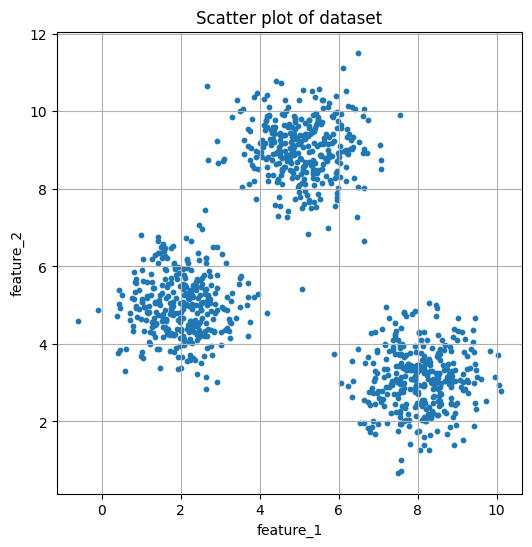

In [3]:
# first, let's visualize the data to inspect any natural groupings
# let's do a scatter plot of feature_1 vs feature_2

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df["feature_1"], df['feature_2'], s=10)
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.title("Scatter plot of dataset")
plt.grid(True)
plt.show()
# we can see that there are three natural clusters (remember: synthetic dataset)

In [4]:
# now, let's be sure to scale the data since K-Means is sensitive to feature scales
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df[["feature_1", "feature_2"]].values
X_scaled = scaler.fit_transform(X)

# How K-Means Clustering Works (Plain Language)

K-Means is an unsupervised machine learning algorithm used to **group similar data points together**. It finds patterns in data without needing labels.

---

## 🔍 The Big Idea
K-Means tries to split your data into **K groups (clusters)**.  
Each group has a **center point** called a *centroid*.  
Data points belong to the cluster whose centroid they are closest to.

---

## 🧠 How It Works Step-by-Step

### 1. Choose the number of clusters (K)
You decide how many groups you want.  
Example: K = 3 → the algorithm will find 3 clusters.

---

### 2. Place K random centroids in the dataset
These are starting guesses.  
They don’t need to be perfect — the algorithm improves them over time.

---

### 3. Assign each data point to the nearest centroid
Using distance (usually Euclidean distance), every point is assigned to the closest centroid.  
This forms temporary clusters.

---

### 4. Recalculate the centroids
For each cluster, K-Means computes a new centroid:  
**the average (mean) position of all points in that cluster**.

---

### 5. Reassign points again
Now that the centroids moved, some points may be closer to a different cluster.  
So points get reassigned.

---

### 6. Repeat steps 4–5 until nothing changes
The centroids keep moving until they settle in stable positions.  
This is called **convergence**.

---

## 🎯 What You Get
- Each data point is grouped into one of the K clusters.
- Each cluster has a final centroid.
- The algorithm finds natural patterns in the data based on similarity.

---

## 👍 Why K-Means Is Useful
- Simple and fast  
- Works well with large datasets  
- Great for pattern discovery, segmentation, and visualization

---

## ⚠️ Things to Keep in Mind
- You must pick K yourself  
- Sensitive to outliers  
- Different starting points can give slightly different results  



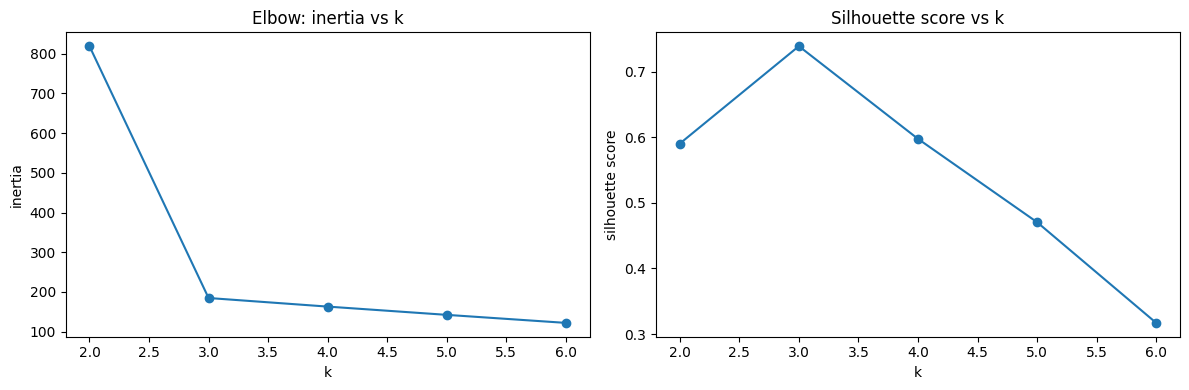

Silhouette scores: {2: np.float64(0.591), 3: np.float64(0.739), 4: np.float64(0.598), 5: np.float64(0.471), 6: np.float64(0.317)}


In [7]:
# next, we need to determine the optimal number of clusters (k) for our K-Means model
# we will use the elbow method and silhouette score to determine k
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = [] # will measure how tightly the points fit inside their clusters, so the lower the better
sil_scores = [] # measures how well separated and well formed the clusters are, so the higher the better
K_range = range(2,7)

# let's try k = range(2,7) to find an optimal number of clusters
for k in K_range:
  km = KMeans(n_clusters=k, random_state=1, n_init=10) # n_init=10 runs the algorithm 10 times with different initial cluster centers and keeps best one
  labels = km.fit_predict(X_scaled)
  inertias.append(km.inertia_)
  sil_scores.append(silhouette_score(X_scaled, labels))

# let's visualize our findings on what the best k value is

# remember that with the elbow method, you are analyzing where the "elbow" is on the plot which in this case is at k=3
# k=3 is optimal according to this method because:
  # below the elbow: clusters are too broad and not descriptive
  # above the elbow: you're overfitting by adding clusters that don't meaningfully improve structure
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, marker='o')
plt.title("Elbow: inertia vs k")
plt.xlabel("k")
plt.ylabel("inertia")

# remember that a silhouette score ranges from -1 to 1:
  # 1: excellent clustering (well separated and tight clusters)
  # 0: overlaps between clusters
  # negative: points are assigned to wrong cluster
  # therefore, the best k is usually the one with the highest silhouette score
# our plot shows k=3 has he best silhouette score of 0.739
plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("silhouette score")

plt.tight_layout()
plt.show()

print("Silhouette scores:", dict(zip(K_range, [round(s,3) for s in sil_scores])))

In [6]:
# now, let's run K-Means with k=3, our optimal k
k = 3
km = KMeans(n_clusters=k, random_state=1, n_init=20) # let's use n_init=20 for better results but longer runtime
labels = km.fit_predict(X_scaled)
centroids_scaled = km.cluster_centers_ # get centroids in scaled space

# make sure to convert the centroids back to non-scaled space
centroids = scaler.inverse_transform(centroids_scaled)

# attach labels from K-Means to dataframe
df["kmeans_label"] = labels

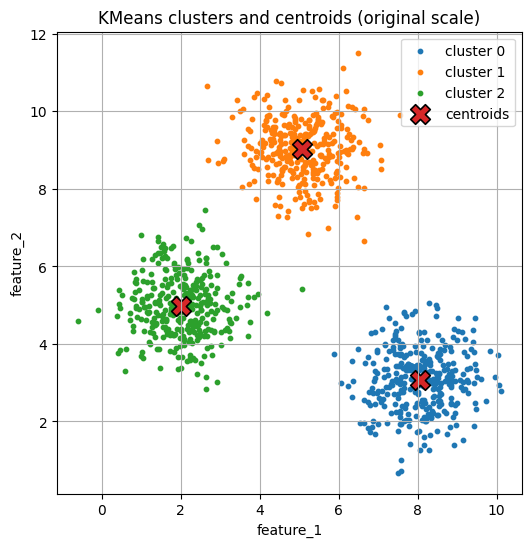

In [8]:
# next, let's visualize the predicted clusters and centroids
plt.figure(figsize=(6,6))
for lab in sorted(df["kmeans_label"].unique()):
    subset = df[df["kmeans_label"] == lab]
    plt.scatter(subset["feature_1"], subset["feature_2"], s=10, label=f"cluster {lab}")

plt.scatter(centroids[:,0], centroids[:,1], s=200, marker='X', edgecolor='k', linewidth=1.2, label='centroids')
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.legend()
plt.title("KMeans clusters and centroids (original scale)")
plt.grid(True)
plt.show()
# we see three fairly well separated and tight clusters along with a centralized centroid in each one

In [12]:
# now, let's do some cluster evaluation to check how well the model performed
# we need to use the silhouette scores to see how well separated clusters are on average
# note that we do not use the inertia because it is scale-dependent and decreases with k
sil = silhouette_score(X_scaled, labels)
print("Silhouette score for k=3: ", round(sil, 3))
# we get a silhouette score of 0.317 which determines a fair separation with some overlap; it is fair but not perfect

# show cluster sizes as well
print("\nCluster sizes:")
print(df["kmeans_label"].value_counts().sort_index())

Silhouette score for k=3:  0.317

Cluster sizes:
kmeans_label
0    333
1    333
2    333
Name: count, dtype: int64


In [15]:
# lastly, let's inspect our centroids and cluster summaries
cluster_summary = df.groupby("kmeans_label")[["feature_1", "feature_2"]].agg(["mean", "std", "count"])
cluster_summary
# the mean from feature_1 and feature_2 shows us where the clusters center around
# cluster 0: centers around (8,3)
# cluster 1: centers around (5,9)
# cluster 2: centers around (2,5)

# the cluster have std of about 0.77-0.82 for both features which makes sense since the dataset was generated using a variance of 0.8
# this means that the clusters are compact, are similiarly sized, and no cluster is oddly stretched or mis-shaped

# we also see that the count was 333 for each cluster which means the model created perfectly balanced cluster sizes

feature_1                 feature_2                
                  mean       std count      mean       std count
kmeans_label                                                    
0             8.055958  0.778662   333  3.076627  0.801498   333
1             5.064084  0.824993   333  9.033024  0.768805   333
2             2.014314  0.773340   333  4.974795  0.798937   333